# Model-Based RL
In this exercise you will implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem.

What is a model and why would we want to use one? In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. While this may seem less useful when the real environment is itself a simulation, like in our CartPole task, it can have huge advantages when attempting to learn policies for acting in the physical world.

How are we going to accomplish this in Tensorflow? We are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment! 

### Loading libraries and starting CartPole environment

In [1]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

### Setting Hyper-parameters

In [4]:
# hyperparameters
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

### Policy Network

In [5]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]

################################################################################
# TODO: Implement the loss function.                                           #
# This sends the weights in the direction of making actions that gave good     #
# advantage (reward overtime) more likely, and actions that didn't less likely.#
################################################################################
loss = -tf.reduce_mean(tf.log(input_y*(input_y-probability)+(1-input_y)*(input_y+probability))*advantages) 
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [6]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions

In [7]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer

def discount_rewards(r):
    ################################################################################
    # TODO: Implement the discounted rewards function                              #
    # Return discounted rewards weighed by gamma. Each reward will be replaced     #
    # with a weight reward that involves itself and all the other rewards occuring #
    # after it. The later the reward after it happens, the less effect it has on   #
    # the current rewards's discounted reward                                      #
    # Hint: [r0, r1, r2, ..., r_N] will look someting like:                        #
    #       [(r0 + r1*gamma^1 + ... r_N*gamma^N), (r1 + r2*gamma^1 + ...), ...]    #
    ################################################################################
    dcr = []
    dcr.append(np.power(gamma, range(len(r))).dot(r))
    for i, ri in enumerate(r[:len(r)-1]):
        dcr.append((dcr[i] - ri) / gamma)
    return np.array(dcr)        
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

## Training the Policy and Model

In [10]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
with tf.Session(config=config) as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            #env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                
                ################################################################################
                # TODO: Run the model network and compute predicted_state                      #
                # Output: 'pState'                                                             #
                ################################################################################
                _previous_state = np.concatenate([epx[:-1], np.absolute(epy-1)[:-1]], axis=1)
                pState, _ = sess.run([predicted_state, updateModel], 
                                     feed_dict={previous_state: _previous_state,
                                                true_observation: epx[1:],
                                                true_reward: epr[1:],
                                                true_done: epd[1:]})
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                

            if trainThePolicy == True:
                
                ################################################################################
                # TODO: Run the policy network and compute newGrads                            #
                # Output: 'tGrad'                                                              #
                ################################################################################
                discounted_epr = discount_rewards(epr)
                discounted_epr = (discount_rewards(epr) - np.mean(discounted_epr)) / np.std(discounted_epr)
                tGrad = sess.run(newGrads, feed_dict={observations:epx, advantages:discounted_epr, input_y:epy})
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    
                    ################################################################################
                    # TODO:                                                                        #
                    # (1) Run the policy network and update gradients                              #
                    # (2) Reset gradBuffer to 0                                                    #
                    ################################################################################
                    sess.run(updateGrads, feed_dict={W1Grad: gradBuffer[0], W2Grad:gradBuffer[1]})
                    resetGradBuffer(gradBuffer)                     
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes
                if episode_number > 100:
                    
                    ################################################################################
                    # TODO: Alternating between training the policy from the model and training    #
                    # the model from the real environment.                                         #
                    ################################################################################
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
                    drawFromModel = not drawFromModel
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

World Perf: Episode 4.000000. Reward 19.666667. action: 1.000000. mean reward 19.666667.
World Perf: Episode 7.000000. Reward 21.000000. action: 0.000000. mean reward 19.680000.
World Perf: Episode 10.000000. Reward 17.333333. action: 0.000000. mean reward 19.656533.
World Perf: Episode 13.000000. Reward 18.666667. action: 1.000000. mean reward 19.646635.
World Perf: Episode 16.000000. Reward 24.000000. action: 0.000000. mean reward 19.690168.
World Perf: Episode 19.000000. Reward 17.333333. action: 0.000000. mean reward 19.666600.
World Perf: Episode 22.000000. Reward 17.666667. action: 0.000000. mean reward 19.646601.
World Perf: Episode 25.000000. Reward 17.333333. action: 0.000000. mean reward 19.623468.
World Perf: Episode 28.000000. Reward 11.666667. action: 1.000000. mean reward 19.543900.
World Perf: Episode 31.000000. Reward 13.333333. action: 0.000000. mean reward 19.481794.
World Perf: Episode 34.000000. Reward 19.000000. action: 1.000000. mean reward 19.476976.
World Perf: 

World Perf: Episode 277.000000. Reward 23.000000. action: 0.000000. mean reward 30.507902.
World Perf: Episode 280.000000. Reward 21.666667. action: 0.000000. mean reward 30.233116.
World Perf: Episode 283.000000. Reward 38.666667. action: 1.000000. mean reward 30.070139.
World Perf: Episode 286.000000. Reward 32.333333. action: 1.000000. mean reward 29.979361.
World Perf: Episode 289.000000. Reward 35.666667. action: 1.000000. mean reward 30.172134.
World Perf: Episode 292.000000. Reward 17.666667. action: 0.000000. mean reward 29.923452.
World Perf: Episode 295.000000. Reward 40.666667. action: 1.000000. mean reward 31.715660.
World Perf: Episode 298.000000. Reward 37.000000. action: 1.000000. mean reward 31.641096.
World Perf: Episode 301.000000. Reward 41.333333. action: 1.000000. mean reward 31.537910.
World Perf: Episode 304.000000. Reward 31.333333. action: 1.000000. mean reward 31.554365.
World Perf: Episode 307.000000. Reward 53.000000. action: 1.000000. mean reward 31.673716.

World Perf: Episode 547.000000. Reward 85.000000. action: 0.000000. mean reward 70.839401.
World Perf: Episode 550.000000. Reward 127.333333. action: 0.000000. mean reward 70.847198.
World Perf: Episode 553.000000. Reward 97.666667. action: 1.000000. mean reward 70.462746.
World Perf: Episode 556.000000. Reward 69.333333. action: 1.000000. mean reward 69.860573.
World Perf: Episode 559.000000. Reward 86.333333. action: 0.000000. mean reward 69.397301.
World Perf: Episode 562.000000. Reward 49.000000. action: 0.000000. mean reward 72.814934.
World Perf: Episode 565.000000. Reward 118.666667. action: 1.000000. mean reward 72.644279.
World Perf: Episode 568.000000. Reward 115.000000. action: 1.000000. mean reward 72.469803.
World Perf: Episode 571.000000. Reward 75.333333. action: 1.000000. mean reward 71.868393.
World Perf: Episode 574.000000. Reward 85.333333. action: 0.000000. mean reward 72.663628.
World Perf: Episode 577.000000. Reward 127.000000. action: 0.000000. mean reward 74.788

World Perf: Episode 817.000000. Reward 163.000000. action: 1.000000. mean reward 103.871765.
World Perf: Episode 820.000000. Reward 137.666667. action: 0.000000. mean reward 106.671684.
World Perf: Episode 823.000000. Reward 158.000000. action: 0.000000. mean reward 106.430229.
World Perf: Episode 826.000000. Reward 200.000000. action: 0.000000. mean reward 106.604980.
World Perf: Episode 829.000000. Reward 200.000000. action: 0.000000. mean reward 108.035927.
World Perf: Episode 832.000000. Reward 182.333333. action: 1.000000. mean reward 110.646858.
World Perf: Episode 835.000000. Reward 186.666667. action: 0.000000. mean reward 110.849968.
World Perf: Episode 838.000000. Reward 177.333333. action: 0.000000. mean reward 112.946892.
World Perf: Episode 841.000000. Reward 153.000000. action: 1.000000. mean reward 112.374092.
World Perf: Episode 844.000000. Reward 117.333333. action: 1.000000. mean reward 113.562843.
World Perf: Episode 847.000000. Reward 143.000000. action: 0.000000. m

World Perf: Episode 1081.000000. Reward 199.000000. action: 1.000000. mean reward 159.578995.
World Perf: Episode 1084.000000. Reward 200.000000. action: 0.000000. mean reward 161.337479.
World Perf: Episode 1087.000000. Reward 200.000000. action: 1.000000. mean reward 160.688065.
World Perf: Episode 1090.000000. Reward 200.000000. action: 1.000000. mean reward 159.765732.
World Perf: Episode 1093.000000. Reward 200.000000. action: 1.000000. mean reward 161.634628.
World Perf: Episode 1096.000000. Reward 200.000000. action: 1.000000. mean reward 161.019730.
World Perf: Episode 1099.000000. Reward 200.000000. action: 0.000000. mean reward 160.124023.
World Perf: Episode 1102.000000. Reward 200.000000. action: 1.000000. mean reward 160.388046.
World Perf: Episode 1105.000000. Reward 200.000000. action: 0.000000. mean reward 162.442612.
World Perf: Episode 1108.000000. Reward 188.666667. action: 1.000000. mean reward 163.401749.
World Perf: Episode 1111.000000. Reward 200.000000. action: 

World Perf: Episode 1345.000000. Reward 200.000000. action: 1.000000. mean reward 183.418564.
World Perf: Episode 1348.000000. Reward 200.000000. action: 1.000000. mean reward 183.261185.
World Perf: Episode 1351.000000. Reward 200.000000. action: 1.000000. mean reward 184.578995.
World Perf: Episode 1354.000000. Reward 200.000000. action: 1.000000. mean reward 185.871140.
World Perf: Episode 1357.000000. Reward 164.666667. action: 0.000000. mean reward 186.766922.
World Perf: Episode 1360.000000. Reward 200.000000. action: 1.000000. mean reward 186.317383.
World Perf: Episode 1363.000000. Reward 200.000000. action: 0.000000. mean reward 187.574417.
World Perf: Episode 1366.000000. Reward 200.000000. action: 1.000000. mean reward 188.792557.
World Perf: Episode 1369.000000. Reward 200.000000. action: 0.000000. mean reward 187.542923.
World Perf: Episode 1372.000000. Reward 200.000000. action: 1.000000. mean reward 186.320557.
World Perf: Episode 1375.000000. Reward 200.000000. action: 

World Perf: Episode 1609.000000. Reward 200.000000. action: 0.000000. mean reward 197.300903.
World Perf: Episode 1612.000000. Reward 200.000000. action: 1.000000. mean reward 195.975418.
World Perf: Episode 1615.000000. Reward 200.000000. action: 1.000000. mean reward 195.672653.
World Perf: Episode 1618.000000. Reward 200.000000. action: 0.000000. mean reward 194.717545.
World Perf: Episode 1621.000000. Reward 200.000000. action: 1.000000. mean reward 193.423508.
World Perf: Episode 1624.000000. Reward 170.333333. action: 1.000000. mean reward 192.088257.
World Perf: Episode 1627.000000. Reward 200.000000. action: 0.000000. mean reward 191.227356.
World Perf: Episode 1630.000000. Reward 200.000000. action: 0.000000. mean reward 190.025131.
World Perf: Episode 1633.000000. Reward 200.000000. action: 1.000000. mean reward 188.863205.
World Perf: Episode 1636.000000. Reward 200.000000. action: 1.000000. mean reward 187.864868.
World Perf: Episode 1639.000000. Reward 200.000000. action: 

World Perf: Episode 1873.000000. Reward 200.000000. action: 1.000000. mean reward 193.610291.
World Perf: Episode 1876.000000. Reward 200.000000. action: 0.000000. mean reward 192.065613.
World Perf: Episode 1879.000000. Reward 200.000000. action: 0.000000. mean reward 193.201660.
World Perf: Episode 1882.000000. Reward 200.000000. action: 1.000000. mean reward 191.576477.
World Perf: Episode 1885.000000. Reward 200.000000. action: 1.000000. mean reward 192.826645.
World Perf: Episode 1888.000000. Reward 200.000000. action: 1.000000. mean reward 191.204208.
World Perf: Episode 1891.000000. Reward 200.000000. action: 0.000000. mean reward 189.842178.
World Perf: Episode 1894.000000. Reward 200.000000. action: 0.000000. mean reward 191.220291.
World Perf: Episode 1897.000000. Reward 200.000000. action: 1.000000. mean reward 189.651596.
World Perf: Episode 1900.000000. Reward 200.000000. action: 0.000000. mean reward 190.840454.
World Perf: Episode 1903.000000. Reward 200.000000. action: 

World Perf: Episode 2137.000000. Reward 200.000000. action: 0.000000. mean reward 212.514450.
World Perf: Episode 2140.000000. Reward 200.000000. action: 0.000000. mean reward 213.270187.
World Perf: Episode 2143.000000. Reward 200.000000. action: 0.000000. mean reward 214.025406.
World Perf: Episode 2146.000000. Reward 200.000000. action: 0.000000. mean reward 214.691818.
World Perf: Episode 2149.000000. Reward 200.000000. action: 1.000000. mean reward 215.408936.
World Perf: Episode 2152.000000. Reward 200.000000. action: 1.000000. mean reward 216.078735.
World Perf: Episode 2155.000000. Reward 200.000000. action: 1.000000. mean reward 216.740707.
World Perf: Episode 2158.000000. Reward 200.000000. action: 1.000000. mean reward 217.425415.
World Perf: Episode 2161.000000. Reward 200.000000. action: 1.000000. mean reward 215.640686.
World Perf: Episode 2164.000000. Reward 200.000000. action: 1.000000. mean reward 216.321396.
World Perf: Episode 2167.000000. Reward 200.000000. action: 

World Perf: Episode 2401.000000. Reward 197.000000. action: 0.000000. mean reward 208.026413.
World Perf: Episode 2404.000000. Reward 200.000000. action: 1.000000. mean reward 208.890671.
World Perf: Episode 2407.000000. Reward 200.000000. action: 1.000000. mean reward 209.715988.
World Perf: Episode 2410.000000. Reward 200.000000. action: 0.000000. mean reward 210.488953.
World Perf: Episode 2413.000000. Reward 200.000000. action: 1.000000. mean reward 211.310715.
World Perf: Episode 2416.000000. Reward 200.000000. action: 0.000000. mean reward 212.072647.
World Perf: Episode 2419.000000. Reward 200.000000. action: 1.000000. mean reward 212.795273.
World Perf: Episode 2422.000000. Reward 200.000000. action: 0.000000. mean reward 211.166306.
World Perf: Episode 2425.000000. Reward 188.000000. action: 0.000000. mean reward 211.817749.
World Perf: Episode 2428.000000. Reward 180.000000. action: 0.000000. mean reward 212.380310.
World Perf: Episode 2431.000000. Reward 200.000000. action: 

### Checking model representation
Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


NameError: name 'state_nextsAll' is not defined

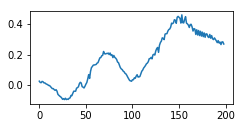

In [11]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i])
plt.tight_layout()